In [109]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [96]:
data = pl.read_excel('Data/CleanedData.xlsx').select('Date', 'CUSIP', 'asset_type', 'credit_rating', 
                                                   'spread', (pl.col('spread') * pl.col('duration')).alias('DTS')).filter(pl.col('spread') != 0)

data = data.sort('Date', 'CUSIP').with_columns(((pl.col('spread') - pl.col('spread').shift(1).over('CUSIP')) / 
                                                pl.col('spread')).alias('pct_spread_chg')).drop_nulls().unique().filter(pl.col('asset_type') == 'Credit', pl.col('credit_rating').is_in(['Aaa', 'Aa1', 'Aa2', 'Aa3', 'A1', 'A2', 'A3', 'Baa1', 'Baa2', 'Baa3']))

vols = data.sort('Date', 'CUSIP').with_columns(pl.col('pct_spread_chg').rolling_std(4 * 36).over('CUSIP').alias('vol')).drop_nulls()

In [155]:
bucket = [75, 110, 135, 160, 200]

vols = vols.with_columns(pl.when(pl.col('spread') < 50)
                           .then(pl.lit('0'))
                        .otherwise(pl.when(pl.col('spread') < 82)
                           .then(pl.lit('1'))
                         .otherwise(pl.when(pl.col('spread') < 115)
                           .then(pl.lit('2'))
                         .otherwise(pl.when(pl.col('spread') < 147)
                           .then(pl.lit('3')).otherwise(pl.lit('4'))))).alias('bucket'))

grouped = vols.group_by('Date').agg(pl.col('vol').mean()).sort('Date')
b0 = grouped#.filter(pl.col('bucket') == '3').sort('Date')

credit = vols.group_by('Date', 'credit_rating').agg(pl.col('vol').mean()).sort('Date')
aa3 = credit.filter(pl.col('credit_rating') == 'Aa3')

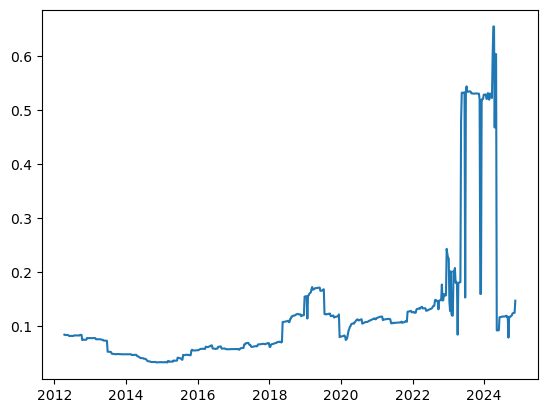

In [160]:
plt.plot(b0['Date'], b0['vol'])

In [158]:
vols.filter(pl.col('CUSIP') == '03838WAA9')

Date,CUSIP,asset_type,credit_rating,spread,DTS,pct_spread_chg,vol,bucket
date,str,str,str,f64,f64,f64,f64,str
2021-11-10,"""03838WAA9""","""Credit""","""Baa1""",69.523422,168.79995,-0.02639,0.553382,"""1"""
2021-11-17,"""03838WAA9""","""Credit""","""Baa1""",72.784668,175.671615,0.044807,0.553363,"""1"""
2021-11-24,"""03838WAA9""","""Credit""","""Baa1""",77.718246,186.502194,0.06348,0.553427,"""1"""
2021-12-01,"""03838WAA9""","""Credit""","""Baa1""",71.326706,169.085524,-0.089609,0.55342,"""1"""
2021-12-08,"""03838WAA9""","""Credit""","""Baa1""",76.912201,181.367353,0.072622,0.553502,"""1"""
…,…,…,…,…,…,…,…,…
2024-07-17,"""03838WAA9""","""Credit""","""Baa2""",96.811256,7.337131,0.032058,0.208045,"""2"""
2024-07-24,"""03838WAA9""","""Credit""","""Baa2""",118.173332,6.714727,0.180769,0.208677,"""3"""
2024-07-31,"""03838WAA9""","""Credit""","""Baa2""",112.928223,4.281673,-0.046446,0.208625,"""2"""


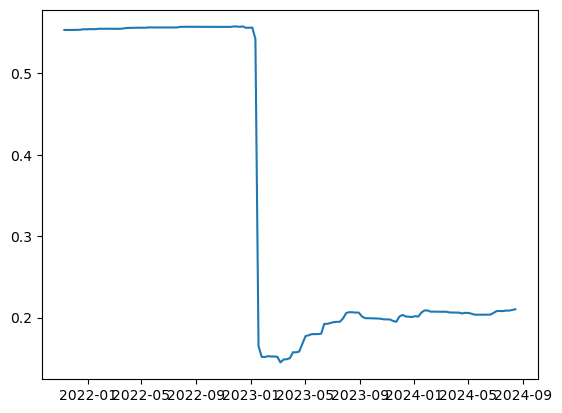

In [159]:
test = vols.filter(pl.col('CUSIP') == '03838WAA9')

plt.plot(test['Date'], test['vol'])